In [122]:
import os
import sys
import random
os.environ["KERAS_BACKEND"] = "tensorflow"

import glob
try:
    if not ("CUDA_VISIBLE_DEVICES" in os.environ):
        os.environ['CUDA_VISIBLE_DEVICES']='0'
        print("importing setGPU")
        import setGPU
except:
    print("Could not import setGPU, please make sure you configure CUDA_VISIBLE_DEVICES manually")
    pass

import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import time
from tqdm import tqdm
import itertools
import io
import sklearn
import sklearn.cluster
import tensorflow as tf
from numpy.lib.recfunctions import append_fields

import scipy
import scipy.special

from mpnn import MessagePassing, ReadoutGraph, Aggregation

In [123]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

version=2.1.0, CUDA=True, GPU=True, TPU=False


In [124]:
try:
    num_gpus = len(os.environ["CUDA_VISIBLE_DEVICES"].split(","))
    print("num_gpus=", num_gpus)
    if num_gpus > 1:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.OneDeviceStrategy("gpu:0")
except Exception as e:
    print(e)
    print("fallback to CPU")
    strategy = tf.distribute.OneDeviceStrategy("cpu")

num_gpus= 1


In [125]:
#tf.config.experimental_run_functions_eagerly(True)

In [126]:
def dist(A,B):
    na = tf.reduce_sum(tf.square(A), -1)
    nb = tf.reduce_sum(tf.square(B), -1)
 
    na = tf.reshape(na, [tf.shape(na)[0], -1, 1])
    nb = tf.reshape(nb, [tf.shape(na)[0], 1, -1])
    Dsq = tf.clip_by_value(na - 2*tf.linalg.matmul(A, B, transpose_a=False, transpose_b=True) + nb, 1e-12, 1e12)
    D = tf.sqrt(Dsq)
    return D


#Given a list of [Nbatch, Nelem, Nfeat] input nodes, computes the dense [Nbatch, Nelem, Nelem] adjacency matrices
class Distance(tf.keras.layers.Layer):

    def __init__(self, dist_shape, *args, **kwargs):
        super(Distance, self).__init__(*args, **kwargs)

    def call(self, inputs1, inputs2):
        #compute the pairwise distance matrix between the vectors defined by the first two components of the input array
        #inputs1, inputs2: [Nbatch, Nelem, distance_dim] embedded coordinates used for element-to-element distance calculation
        D = dist(inputs1, inputs2)
      
        #adjacency between two elements should be high if the distance is small.
        #this is equivalent to radial basis functions. 
        #self-loops adj_{i,i}=1 are included, as D_{i,i}=0 by construction
        adj = tf.math.exp(-1.0*D)

        #optionally set the adjacency matrix to 0 for low values in order to make the matrix sparse.
        #need to test if this improves the result.
        #adj = tf.keras.activations.relu(adj, threshold=0.01)

        return adj

In [127]:
class InputEncoding(tf.keras.layers.Layer):
    def __init__(self, num_input_classes):
        super(InputEncoding, self).__init__()
        self.num_input_classes = num_input_classes
        
    def call(self, X):
        #X: [Nbatch, Nelem, Nfeat] array of all the input detector element feature data

        #X[:, :, 0] - categorical index of the element type
        Xid = tf.one_hot(tf.cast(X[:, :, 0], tf.int32), self.num_input_classes)

        #X[:, :, 1:] - all the other non-categorical features
        Xprop = X[:, :, 1:]
        return tf.concat([Xid, Xprop], axis=-1)

In [128]:
## Graph Highway network
# https://arxiv.org/pdf/2004.04635.pdf
#https://github.com/gcucurull/jax-ghnet/blob/master/models.py 
class GHConv(tf.keras.layers.Layer):
    def __init__(self, k, *args, **kwargs):
        self.activation = kwargs.pop("activation")
        self.hidden_dim = args[0]
        self.k = k

        super(GHConv, self).__init__(*args, **kwargs)

        self.W_t = self.add_weight(shape=(self.hidden_dim, self.hidden_dim), name="w_t", initializer="random_normal")
        self.b_t = self.add_weight(shape=(self.hidden_dim, ), name="b_t", initializer="zeros")
        self.W_h = self.add_weight(shape=(self.hidden_dim, self.hidden_dim), name="w_h", initializer="random_normal")
        self.theta = self.add_weight(shape=(self.hidden_dim, self.hidden_dim), name="theta", initializer="random_normal")
 
    def call(self, x, adj):
        #compute the normalization of the adjacency matrix
        in_degrees = tf.reduce_sum(adj, axis=-1)
        #add epsilon to prevent numerical issues from 1/sqrt(x)
        norm = tf.expand_dims(tf.pow(in_degrees + 1e-6, -0.5), -1)
        norm_k = tf.pow(norm, self.k)
        adj_k = tf.pow(adj, self.k)

        f_hom = tf.linalg.matmul(x, self.theta)
        f_hom = tf.linalg.matmul(adj_k, f_hom*norm_k)*norm_k

        f_het = tf.linalg.matmul(x, self.W_h)
        gate = tf.nn.sigmoid(tf.linalg.matmul(x, self.W_t) + self.b_t)
        #tf.print(tf.reduce_mean(f_hom), tf.reduce_mean(f_het), tf.reduce_mean(gate))

        out = gate*f_hom + (1-gate)*f_het
        return out

## Simple Graph Conv layer
class SGConv(tf.keras.layers.Dense):
    def __init__(self, k, *args, **kwargs):
        super(SGConv, self).__init__(*args, **kwargs)
        self.k = k
    
    def call(self, inputs, adj):
        W = self.weights[0]
        b = self.weights[1]

        #compute the normalization of the adjacency matrix
        in_degrees = tf.reduce_sum(adj, axis=-1)
        #add epsilon to prevent numerical issues from 1/sqrt(x)
        norm = tf.expand_dims(tf.pow(in_degrees + 1e-6, -0.5), -1)
        norm_k = tf.pow(norm, self.k)

        support = (tf.linalg.matmul(inputs, W))
     
        #k-th power of the normalized adjacency matrix is nearly equivalent to k consecutive GCN layers
        adj_k = tf.pow(adj, self.k)
        out = tf.linalg.matmul(adj_k, support*norm_k)*norm_k

        return self.activation(out + b)

In [129]:
#Simple message passing based on a matrix multiplication
class DNNSuperCluster(tf.keras.Model):
    
    def __init__(self, activation=tf.nn.selu, nclass_labels=2, 
                     hidden_dim_coord=256, hidden_dim_input=256, hidden_dim_id=256,     
                     n_layers_input=2, n_layers_id=3, n_layers_coord=2,
                     distance_dim=256, num_conv=4, convlayer="ghconv", dropout=0.1):
        super(DNNSuperCluster, self).__init__()
        self.activation = activation
        self.nclass_labels = nclass_labels

        #self.enc = InputEncoding(3)
        
        # layers for distance coordinate extraction
        self.layers_coord = [ ]
        for i in range(n_layers_coord):
            layer_coord_i = tf.keras.layers.Dense(hidden_dim_coord, activation=activation, name="disctcoords_"+str(i))
            self.layers_coord.append(layer_coord_i)

        self.layer_distcoords = tf.keras.layers.Dense(distance_dim, activation="linear", name="distcoords_final")
        self.layer_distance = Distance(distance_dim, name="distance")

        # layers for feature extraction 
        self.layers_input = [ ]
        for i in range(n_layers_input):
            layer_input_i = tf.keras.layers.Dense(hidden_dim_input, activation=activation, name="input_"+str(i))
            layer_input_i_do = tf.keras.layers.Dropout(dropout)
            self.layers_input.append((layer_input_i, layer_input_i_do))
        
       

        # Graph convolutions
        if convlayer == "sgconv":
            self.layer_conv1 = SGConv(num_conv, hidden_dim_input, activation=activation, name="conv1")
            #self.layer_conv2 = SGConv(num_conv, 2*hidden_dim+len(class_labels), activation=activation, name="conv2")
        elif convlayer == "ghconv":
            self.layer_conv1 = GHConv(num_conv, hidden_dim_input, activation=activation, name="conv1")
            #self.layer_conv2 = GHConv(num_conv, 2*hidden_dim+len(class_labels), activation=activation, name="conv2")

        # Output layers
        self.layers_id = [ ]
        for i in range(n_layers_id):
            layer_id_i = tf.keras.layers.Dense(hidden_dim_id, activation=activation, name="id_"+str(i))
            #layer_id_i_do = tf.keras.layers.Dropout(dropout)
            self.layers_id.append(layer_id_i)
            
        #self.layer_id3 = tf.keras.layers.Dense(hidden_dim, activation=activation, name="id3")
        self.layer_id = tf.keras.layers.Dense(nclass_labels, activation="linear", name="out_id")
        
 
    def predict_distancematrix(self, inputs, msk_elem, training=True):
        x = inputs
        for layer_coord in self.layers_coord:
            x = layer_coord(x)

        distcoords = self.layer_distcoords(x)
        
        masked_distcoords = distcoords*msk_elem

        dm = self.layer_distance(masked_distcoords, masked_distcoords)
        
        dm = dm*msk_elem

        return dm

    #@tf.function(input_signature=[tf.TensorSpec(shape=[None, 15], dtype=tf.float32)])
    def call(self, inputs, training=True):
        # separate cluster energies from rescaled inputs
        X = inputs[:,:,1:]
        cl_energies = inputs[:,:,0]
        
        # the 4th element in the scaled input is the en_cluster. used to check for the mask
        msk_input = tf.expand_dims(tf.cast(X[:, :, 3] != 0., tf.float32), -1)

        dm = self.predict_distancematrix(X, msk_elem=msk_input, training=training)
        
        x = X
        for layer_input, layer_input_do in self.layers_input:
            x = layer_input(x)
            x = layer_input_do(x, training)
            
        x = self.layer_conv1(x, dm)
        
        for layer_id in self.layers_id:
            x = layer_id(x)
            #x = layer_id_do(x, training)
            
        out_id_logits = self.layer_id(x)
        
        energies = tf.expand_dims(cl_energies, axis=-1)
        # add the cluster energies in the output, in the future we can add here corrections
        output = tf.concat([out_id_logits,energies], axis=-1)
        # mask to 0 the padded output
        output_masked = output * msk_input
        
        #return masked output logits and the predicted total energy
        return output_masked,  dm

# Loss definition

In [130]:
#@tf.function
def separate_true(y, nclass_labels):
    # one-hot encoding for true label (signal,PU,noise)
    # the padded elements have -1 so they are one_hot to (0,0)
    y_onehot = tf.one_hot(tf.cast(y[:,1:], tf.int32), nclass_labels)
    true_en = y[:,0]
    return y_onehot, true_en

#@tf.function
def true_mask(y):
    # mask for elements that should be included in supercluster
    in_sc = tf.cast(y[:,1:] == 1., tf.float32)
    # number of padding elements
    padded = tf.reduce_sum(tf.cast(y[:,1:] == -1., tf.float32), axis=-1)
    return in_sc, padded
    
#@tf.function
def separate_pred(ypred):
    ens = ypred[:,:,2]
    ypred_onehot = ypred[:,:,:2]
    # 0 not include in energy sum, 1 include in energy sum
    # masked elements have pred_id=0 so they do not enter in the energy sum
    pred_id = tf.cast(tf.argmax(ypred_onehot, axis=-1), tf.float32)
    # predicted total energy
    pred_en =  tf.reduce_sum( ens * pred_id, axis=-1)
    # one-hot encoding for true label (signal,PU,noise)
    return ypred_onehot, pred_en, pred_id
    
def separate_pred_softmax(ypred):
    ens = ypred[:,:,2]
    ypred_onehot = ypred[:,:,:2]
    # 0 not include in energy sum, 1 include in energy sum
    # masked elements have pred_id=0 so they do not enter in the energy sum
    pred_id = tf.cast(tf.argmax(ypred_onehot, axis=-1), tf.float32)
    # predicted total energy
    pred_en =  tf.reduce_sum( ens * pred_id, axis=-1)
    # one-hot encoding for true label (signal,PU,noise)
    return ypred_onehot, pred_en, pred_id

In [131]:
#@tf.function
def mse_unreduced(true, pred):
    return tf.math.pow(true-pred,2)

#@tf.function
def msle_unreduced(true, pred):
    return tf.math.pow(tf.math.log(tf.math.abs(true) + 1.0) - tf.math.log(tf.math.abs(pred) + 1.0), 2)


#@tf.function
def my_loss_full(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    # since the padded y_true is -1 -> it gives [0,0] when it is onehot. The ypred for batched is [0,0] so the loss
    # is automatically 0 for padded samples
    l1 = tf.nn.softmax_cross_entropy_with_logits(y_true_onehot, y_pred_onehot)
    
    # true energy loss
    mask_outsc = tf.cast(true_en == 0., tf.float32)
    mask_insc = tf.cast(true_en != 0., tf.float32)
    n_outsc = tf.reduce_sum(mask_outsc)
    n_insc = tf.reduce_sum(mask_insc)
    
    l2_en = mse_unreduced(true_en, pred_en)
    l2_en_log = msle_unreduced(true_en, pred_en)
    
    # separate mean resolution for windows with Caloparticle or not
    l2_en_outsc = tf.reduce_sum(l2_en * mask_outsc) / n_outsc
    l2_en_insc = tf.reduce_sum(l2_en * mask_insc) / n_insc
    l2_en_outsc_log = tf.reduce_sum(l2_en_log * mask_outsc) / n_outsc
    l2_en_insc_log = tf.reduce_sum(l2_en_log * mask_insc) / n_insc
    
    ltot = 2e4*tf.reduce_mean(l1) + 20* l2_en_insc +   10*l2_en_outsc + 200* l2_en_insc_log  + 100* l2_en_outsc_log
    
    return ltot


In [132]:
def energy_resolution_outsc(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_outsc = tf.cast(true_en == 0., tf.float32)
    n_outsc = tf.reduce_sum(mask_outsc)
    return tf.reduce_sum(mse_unreduced(true_en, pred_en)*mask_outsc) / n_outsc

def energy_resolution_insc(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_insc = tf.cast(true_en != 0., tf.float32)
    n_insc = tf.reduce_sum(mask_insc)
    return tf.reduce_sum(mse_unreduced(true_en, pred_en)*mask_insc) / n_insc

def energy_resolution_outsc_log(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_outsc = tf.cast(true_en == 0., tf.float32)
    n_outsc = tf.reduce_sum(mask_outsc)
    return tf.reduce_sum(msle_unreduced(true_en, pred_en)*mask_outsc) / n_outsc

def energy_resolution_insc_log(y_true, y_pred):
    y_true_onehot, true_en = separate_true(y_true, args.nclass_labels)
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    mask_insc = tf.cast(true_en != 0., tf.float32)
    n_insc = tf.reduce_sum(mask_insc)
    return tf.reduce_sum(msle_unreduced(true_en, pred_en)*mask_insc) / n_insc

In [133]:
def get_tpfn_metrics(y_true, y_pred):
    y_true_mask, n_padded = true_mask(y_true)
    y_false_mask = (tf.cast(y_true_mask == 0., tf.float32))
    
    # pred_id contains the last n_padded elements to 0 that will be always True negatives
    y_pred_onehot, pred_en, pred_id = separate_pred(y_pred)
    
    n_pos = tf.reduce_sum(y_true_mask, axis=-1)
    n_neg = tf.reduce_sum(y_false_mask, axis=-1) - n_padded
    
    n_tot = n_neg + n_pos
    
    true_pos = tf.reduce_sum(pred_id * y_true_mask, axis=-1)
    false_neg = n_pos - true_pos
    
    false_pos = tf.reduce_sum(pred_id * y_false_mask, axis=-1)
    true_neg = n_neg - false_pos
    
    return n_tot, true_pos, false_neg, false_pos, true_neg, 

In [134]:
def precision(tp,tn,fp,fn):
    return tp/(tp+fp)

def recall(tp,tn,fp,fn):
    return tp/(tp+fn)

def accuracy(tp,tn,fp,fn):
    return (tp+tn)/(tp+tn+fp+fn)

In [135]:
class Precision(tf.keras.metrics.Metric):

    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        n_tot, true_pos, false_neg, false_pos, true_neg = get_tpfn_metrics(y_true, y_pred)
        self.tp.assign_add(tf.reduce_sum(true_pos))
        self.fp.assign_add(tf.reduce_sum(false_pos))

    def result(self):
        return self.tp / (self.tp + self.fp)

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        
class Recall(tf.keras.metrics.Metric):

    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        n_tot, true_pos, false_neg, false_pos, true_neg = get_tpfn_metrics(y_true, y_pred)
        self.tp.assign_add(tf.reduce_sum(true_pos))
        self.fn.assign_add(tf.reduce_sum(false_neg))

    def result(self):
        return self.tp / (self.tp + self.fn)

    def reset_states(self):
        self.tp.assign(0)
        self.fn.assign(0)


### Settings

In [136]:
data_path = "/storage/ECAL/training_data/window_data/electrons/recordio_v5"
models_path = "/storage/ECAL/deepcluster/models/gcn_models_v9/"

#rain_steps_per_epoch = 
#eval_steps_per_epoch = 3e5 // batch_size
from collections import namedtuple
Args = namedtuple('args', [ 'models_path', 'load','nepochs','ntrain','nval','nfeatures',
                            'n_seed_features','batch_size','lr_decay','lr',
                            'hidden_dim_input','hidden_dim_coord', 'hidden_dim_id',
                            'n_layers_input', 'n_layers_id', 'n_layers_coord',
                           'distance_dim','num_conv','dropout','convlayer',
                           'nclass_labels', 'opt'])

args = Args(models_path='/storage/ECAL/deepcluster/models/gcn_models_v9/',
       load=models_path + "run_12/weights.100-578.179582.hdf5", 
       nepochs=100, 
       ntrain=500000, 
       nval=800000, 
       nfeatures=13, 
       n_seed_features=12,
       batch_size=200, 
       lr_decay=0, 
       lr=1e-05,
       hidden_dim_input=100, 
       hidden_dim_coord=50, 
       hidden_dim_id=100, 
       n_layers_input=3, 
       n_layers_id=2, 
       n_layers_coord=2, 
       distance_dim=30, 
       num_conv=2, 
       dropout=0.01, 
       convlayer='sgconv',
       nclass_labels=2, 
       opt='adam')

### Dataset loading

In [137]:
def scale_features_clusters(X):
    '''
    'is_seed',"cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
    "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
    "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth
    '''
    x_mean = tf.constant( 
        [   0.,  -7.09402501e-04, -1.27142875e-04,  1.30375508e+00,  5.67249500e-01, 
            1.92096066e+00,  1.31476120e-02,  1.62948213e-05,  1.42948806e-02,
            5.92920497e-01,  1.49597644e+00,  3.36213188e-03,  3.06446267e-03]
        )

    x_scale = tf.constant(
        [  1.,  1.10279784e-01, 3.30488055e-01, 2.62605247e+00, 1.16284769e+00,
            7.81094814e+00, 1.70392176e-02, 3.05995567e-04, 1.80176053e-02,
            1.99316624e+00, 1.88845046e+00, 4.12315715e-03, 4.79639033e-03]       
        )
    return (X-x_mean)/ x_scale

def scale_features_seed(X):
    '''
     "seed_eta", "seed_iz","en_seed","et_seed",
     "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
     "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
    '''
    x_mean = tf.constant( 
        [   6.84241156e-03,  1.62242679e-03,  5.81495577e+01,  2.57215845e+01, 
            1.00772582e+00,  1.35803461e-02, -4.29317013e-06,  1.71072024e-02,
            4.90466869e-01,  5.10511982e+00,  8.82101138e-03,  1.04095965e-02 ]
    
        )

    x_scale = tf.constant(
        [   1.31333380e+00, 5.06988411e-01, 9.21157365e+01, 2.98580765e+01, 
            1.17047757e-01, 1.11969442e-02, 1.86572967e-04, 1.31036359e-02,
            4.01511744e-01, 5.67007350e+00, 6.14304203e-03, 7.24808860e-03]       
        )
    return (X-x_mean)/ x_scale

In [138]:
def _parse_tfr_element(element):
    parse_dic = {
        'X':      tf.io.FixedLenFeature([], tf.string),
        'X_seed': tf.io.FixedLenFeature([], tf.string),
        'y':      tf.io.FixedLenFeature([], tf.string),
        'n_clusters': tf.io.FixedLenFeature([], tf.int64)
    }
    example_message = tf.io.parse_single_example(element, parse_dic)

    X = example_message['X']
    X_seed = example_message['X_seed']
    y = example_message['y']
    nclusters = example_message['n_clusters']
    
    arr_X = tf.io.parse_tensor(X, out_type=tf.float32)
    arr_X_seed = tf.io.parse_tensor(X_seed, out_type=tf.float32)
    arr_y = tf.io.parse_tensor(y, out_type=tf.float32)
    
    #https://github.com/tensorflow/tensorflow/issues/24520#issuecomment-577325475
    arr_X.set_shape(     tf.TensorShape((None, args.nfeatures)))
    arr_X_seed.set_shape(tf.TensorShape((1, args.n_seed_features)))
    arr_y.set_shape(     tf.TensorShape((None,)))
 
    return arr_X, arr_X_seed, nclusters, arr_y
  
def _stack_seed_features(arr_X, arr_X_seed, nclusters, arr_y):
    en_clusters = tf.expand_dims(arr_X[:,3], axis=-1)
    rescaled_X = scale_features_clusters(arr_X)
    rescaled_X_seed = scale_features_seed(arr_X_seed)
    X = tf.concat([en_clusters, rescaled_X, tf.broadcast_to(rescaled_X_seed,[nclusters,rescaled_X_seed.shape[1]] )],
                  axis=1)
    return X,arr_y, arr_X_seed,arr_X

In [139]:
# padding shape
ps = ([None,args.nfeatures+args.n_seed_features+1],[None,], [None,args.n_seed_features],[None,args.nfeatures])

# Create datasets from TFRecord files.
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/training-*'.format(data_path)))
dataset = dataset.map(_parse_tfr_element,num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.map(_stack_seed_features,num_parallel_calls=tf.data.experimental.AUTOTUNE) # deterministic=False in TFv2.3
#dataset = dataset.shuffle(10000, reshuffle_each_iteration=True)

#ds_train = dataset.take(args.ntrain).padded_batch(args.batch_size, padded_shapes=ps, drop_remainder=True,padding_values=(0.,-1.,0.,0.))
ds_test = dataset.skip(args.ntrain).take(args.nval).padded_batch(args.batch_size, padded_shapes=ps, drop_remainder=True,padding_values=(0.,-1.,0.,0.))

#ds_train_r = ds_train.repeat(args.nepochs)
ds_test_r = ds_test.repeat(args.nepochs)



In [19]:
di = iter(ds_test)
d = next(di)

In [20]:
d

(<tf.Tensor: shape=(200, 23, 26), dtype=float32, numpy=
 array([[[ 8.9508636e+01,  1.0000000e+00,  6.4327521e-03, ...,
           1.5782517e-01,  1.4854391e+00,  1.2212325e+00],
         [ 6.4714456e+00,  0.0000000e+00,  1.5745438e+00, ...,
           1.5782517e-01,  1.4854391e+00,  1.2212325e+00],
         [ 4.3975401e+00,  0.0000000e+00, -3.0901632e-01, ...,
           1.5782517e-01,  1.4854391e+00,  1.2212325e+00],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],
 
        [[ 6.5756974e+00,  1.0000000e+00,  6.4327521e-03, ...,
          -7.2399759e-01, -7.2538412e-01, -1.4325502e+00],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          

In [140]:
with strategy.scope():
    model = DNNSuperCluster(hidden_dim_input=args.hidden_dim_input,hidden_dim_coord=args.hidden_dim_coord,
                            hidden_dim_id=args.hidden_dim_id, 
                           n_layers_input=args.n_layers_input, n_layers_id=args.n_layers_id, n_layers_coord=args.n_layers_coord,
                            nclass_labels=args.nclass_labels, 
                            distance_dim=args.distance_dim, 
                            num_conv=args.num_conv, convlayer=args.convlayer, dropout=args.dropout)
   

In [141]:
if args.load:
    #ensure model input size is known
    for X, y, X_seed, X_noscale in ds_test:
        model(X)
        break

    model.load_weights(args.load)


# Activations investigation

In [142]:
it = iter(ds_test)
X, y, X_seed, X_noscale = next(it)


In [211]:
datas = defaultdict(list)

for ib, (X, y, X_seed, X_noscale) in enumerate(ds_test):
    ypred, dm = model(X)
    
    datas['deta_1'].append(X_noscale[:,1,1])
    datas['dphi_1'].append(X_noscale[:,1,2])
    datas['adj_seed_cl_1'].append(dm[:,0,1])
    
    print('.',end='')
    if ib >1000 : break

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [212]:
data_final = {}

for k,v in datas.items():
    data_final[k] = np.concatenate(v)
        
import pandas as pd
df = pd.DataFrame(data_final)

In [213]:
df

,deta_1,dphi_1,adj_seed_cl_1
0,0.172931,0.058742,1.733274e-03
1,0.000000,0.000000,4.763163e-17
2,0.109346,-0.351891,5.862454e-11
3,0.087935,0.367916,1.110782e-05
4,0.091397,-0.574286,2.140006e-01
...,...,...,...
200395,-0.025106,-0.370938,5.999745e-01
200396,0.096581,-0.026845,2.899696e-01
200397,-0.000917,-0.047992,1.341251e-01
200398,0.015146,0.202546,7.874019e-01


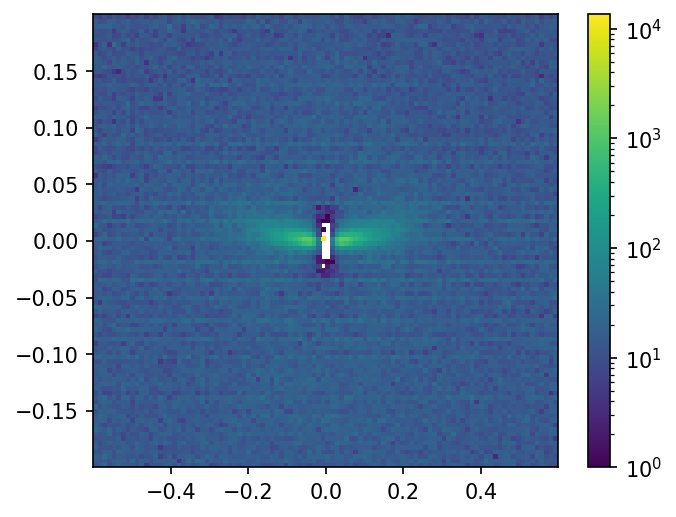

In [214]:
ncount, *_ = plt.hist2d(df.dphi_1, df.deta_1,  bins=(100,100), norm=colors.LogNorm())
plt.colorbar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


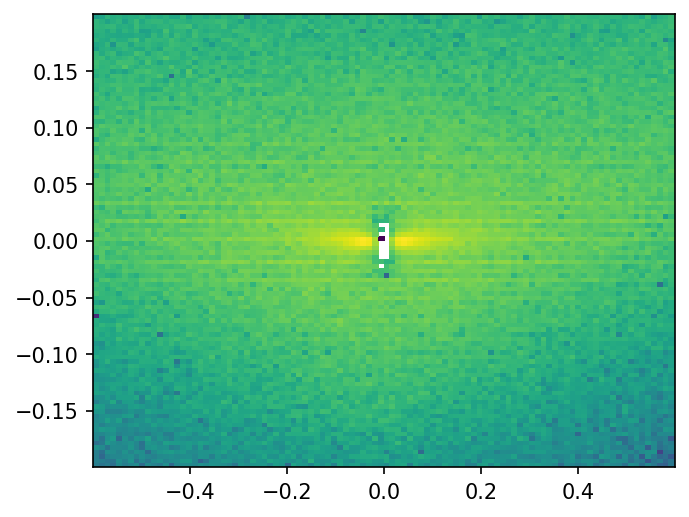

In [215]:
h, *a = plt.hist2d(df.dphi_1, df.deta_1, weights=df.adj_seed_cl_1, bins=(100,100), norm=colors.LogNorm(), vmin=1e-5)
p = h / ncount



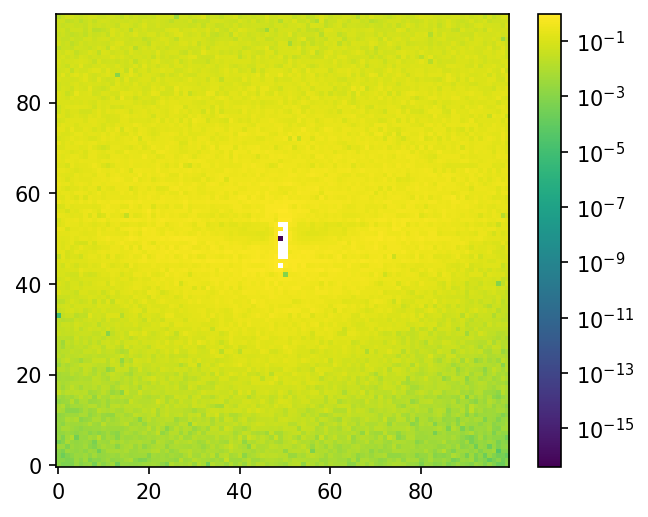

In [217]:
plt.imshow(p.T, norm=colors.LogNorm())
plt.colorbar()

In [ ]:
plt.hist2d(df.dphi_1, df.deta_1,  bins=(100,100), norm=colors.LogNorm())

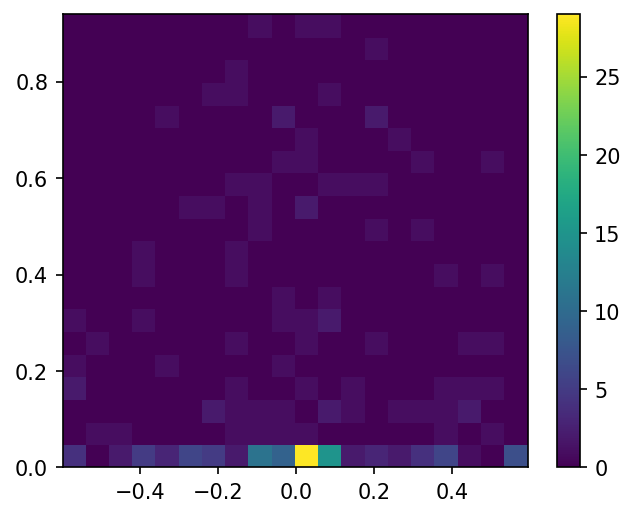

In [177]:
plt.hist2d(X_noscale[:,1,2],dm[:,0,1], bins=(20,20))
plt.colorbar()

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([1.73327385e-03, 4.76316339e-17, 5.86245358e-11, 1.11078243e-05,
       2.14000553e-01, 2.41455715e-02, 1.18234573e-06, 9.47437361e-02,
       2.60389388e-12, 4.44502405e-07, 2.58958280e-01, 5.77275336e-01,
       1.32011041e-01, 5.07573247e-01, 3.95019455e-21, 7.37684639e-03,
       7.98239231e-01, 2.32779610e-04, 1.17280163e-01, 4.87533768e-17,
       7.86200166e-01, 5.21947369e-02, 2.28134479e-04, 2.45554023e-04,
       3.15730363e-01, 4.54876026e-05, 2.85709277e-02, 2.85918325e-01,
       1.17072719e-04, 1.84052521e-06, 4.91511249e-17, 3.92863015e-03,
       7.77475476e-01, 3.32581699e-01, 2.68359855e-03, 4.98724165e-17,
       3.04563120e-02, 1.04000392e-04, 5.62375426e-01, 5.11292786e-09,
       3.03100218e-17, 1.21008924e-07, 5.54852411e-02, 8.39808732e-02,
       1.45026088e-01, 1.41442008e-02, 1.50167292e-08, 1.16324008e-01,
       2.20906198e-01, 2.60594142e-08, 6.66845441e-01, 0.00000000e+00,
       7.06729591e-01, 4.3773

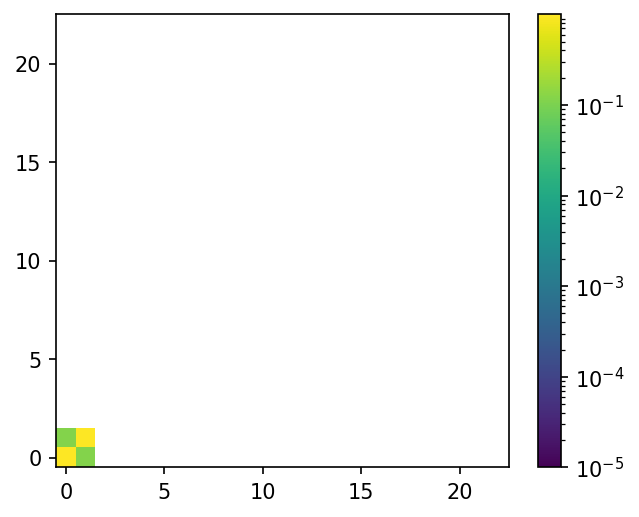

In [163]:
plt.imshow(dm[18], norm=colors.LogNorm(), vmin=1e-5)
plt.colorbar()

In [156]:
dm[2]

<tf.Tensor: shape=(23, 23), dtype=float32, numpy=
array([[9.99998927e-01, 5.86245358e-11, 9.00329367e-10, 3.03795566e-08,
        7.81533727e-10, 1.66246822e-10, 5.46314389e-08, 2.41447271e-08,
        1.00056974e-09, 3.48149709e-09, 1.39064138e-08, 4.13523021e-10,
        3.14204149e-11, 2.12549609e-23, 2.12549609e-23, 2.12549609e-23,
        2.12549609e-23, 2.12549609e-23, 2.12549609e-23, 2.12549609e-23,
        2.12549609e-23, 2.12549609e-23, 2.12549609e-23],
       [5.86245358e-11, 9.84496474e-01, 5.64761087e-03, 2.23348434e-06,
        5.18813683e-03, 4.90300693e-02, 2.11653827e-07, 2.09030736e-06,
        2.81785731e-03, 1.30190689e-04, 1.76750327e-05, 1.41699752e-02,
        7.31383115e-02, 7.83277291e-20, 7.83277291e-20, 7.83277291e-20,
        7.83277291e-20, 7.83277291e-20, 7.83277291e-20, 7.83277291e-20,
        7.83277291e-20, 7.83277291e-20, 7.83277291e-20],
       [9.00329367e-10, 5.64761087e-03, 9.84496474e-01, 2.88081123e-04,
        1.44847453e-01, 3.66900042e-02, 2.83

## Evalutation plots

In [43]:
from collections import defaultdict
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#mport mplhep as hep
#lt.style.use(hep.style.CMS)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,4)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [260]:
#thrs = [0.5,0.6,0.7,0.8,0.9]
thrs = [0.5]

data_calo = defaultdict(list)
data_nocalo = defaultdict(list)


for ib, (X, y, X_seed, X_noscale) in enumerate(ds_test):
    if ib % 10 == 0: print(".",end="")
        
    ypred = model(X)
    #print(ypred)
    
    ens = ypred[:,:,2]
    ypred_onehot = tf.nn.softmax(ypred[:,:,:2])
    
    ytrue_onehot, true_en = separate_true(y,2)
    in_sc_true, padded = true_mask(y)
    
    calo_match_mask = in_sc_true[:,0]==1
    nocalo_match_mask = tf.math.logical_not( calo_match_mask )
    
    
    for thr in thrs:
        mask = tf.cast(ypred_onehot[:,:,1]  > thr, tf.float32).numpy()
        mask_withseed = mask[:]
        mask_withseed[:,0] = 1
        pred_en = tf.reduce_sum( ens * mask_withseed, axis=-1)

        tp =  tf.cast((in_sc_true * mask_withseed) ==1, tf.float32)
        fp =  tf.cast((in_sc_true - mask_withseed) <0, tf.float32)
        fn =  tf.cast((in_sc_true - mask_withseed) >0, tf.float32)

        #do not count seeds for the ncls metrics
        nclusters = X.shape[1] - padded - 1 
        
        data_calo['thres'].append(thr* np.ones(tf.reduce_sum(tf.cast(calo_match_mask,tf.int32)).numpy()))
        data_nocalo['thres'].append(thr* np.ones(tf.reduce_sum(tf.cast(nocalo_match_mask,tf.int32)).numpy()))
        
        data_calo['seed_eta'].append(tf.boolean_mask(X_seed[:,0,0],calo_match_mask).numpy())
        data_calo['seed_en'].append(tf.boolean_mask(X_seed[:,0,2],calo_match_mask).numpy())
        data_calo['seed_et'].append(tf.boolean_mask(X_seed[:,0,3],calo_match_mask).numpy())
        data_calo['ncls'].append(tf.boolean_mask(nclusters,calo_match_mask).numpy())
        data_calo['ncls_sel'].append(tf.reduce_sum(tf.boolean_mask(mask_withseed, calo_match_mask),axis=-1).numpy() - 1)
        data_calo['ncls_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true,calo_match_mask), axis=-1).numpy() -1 )
        data_calo['ncls_sel_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true*mask_withseed, calo_match_mask),axis=-1).numpy() -1)
        data_calo['seed_sel'].append(tf.boolean_mask(tf.cast(mask[:,0],tf.int32),calo_match_mask))
        data_calo['EoEtrue'].append(tf.boolean_mask(pred_en / true_en, calo_match_mask).numpy())
        data_calo['Etrue'].append(tf.boolean_mask(true_en, calo_match_mask).numpy())
        data_calo['Epred'].append(tf.boolean_mask( pred_en, calo_match_mask).numpy())
        data_calo['E_tp'].append(tf.boolean_mask( tf.reduce_sum(ens*tp, axis=-1), calo_match_mask).numpy())
        data_calo['E_fp'].append(tf.boolean_mask( tf.reduce_sum(ens*fp, axis=-1), calo_match_mask).numpy())
        data_calo['E_fn'].append(tf.boolean_mask( tf.reduce_sum(ens*fn, axis=-1), calo_match_mask).numpy())

        data_nocalo['seed_eta'].append(tf.boolean_mask(X_seed[:,0,0],nocalo_match_mask).numpy())
        data_nocalo['seed_en'].append(tf.boolean_mask(X_seed[:,0,2],nocalo_match_mask).numpy())
        data_nocalo['seed_et'].append(tf.boolean_mask(X_seed[:,0,3],nocalo_match_mask).numpy())
        data_nocalo['ncls'].append(tf.boolean_mask(nclusters,nocalo_match_mask).numpy()+1)
        data_nocalo['ncls_sel'].append(tf.reduce_sum(tf.boolean_mask(mask, nocalo_match_mask),axis=-1).numpy())
        data_nocalo['ncls_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true,nocalo_match_mask), axis=-1).numpy())
        data_nocalo['ncls_sel_true'].append(tf.reduce_sum(tf.boolean_mask(in_sc_true*mask_withseed, nocalo_match_mask),axis=-1).numpy())
        data_nocalo['Econt'].append(tf.boolean_mask(pred_en, nocalo_match_mask).numpy())
        data_nocalo['seed_sel'].append(tf.boolean_mask(tf.cast(mask[:,0],tf.int32),nocalo_match_mask))
    
    #if ib>4: break

................................................................................................................................................................................................................................................................................................................................................................................................................

In [262]:
data_final_calo = {}
data_final_nocalo = {}

for k,v in data_calo.items():
    data_final_calo[k] = np.concatenate(v)
    
for k,v in data_nocalo.items():
    data_final_nocalo[k] = np.concatenate(v)
    
import pandas as pd
dfc = pd.DataFrame(data_final_calo)
dfnc = pd.DataFrame(data_final_nocalo)

In [263]:
import pickle
pickle.dump(dfc, open("df_calo_0.5.pkl","wb"))
pickle.dump(dfnc, open("df_nocalo_0.5.pkl","wb"))

In [264]:
import pickle
dfc = pickle.load(open("df_calo.pkl","rb"))
dfc05 = pickle.load(open("df_calo_0.5.pkl","rb"))

In [267]:
dfc = pd.concat([dfc,dfc05])

In [268]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.3,2.6,3]
ncls = [0,2,3,5,10,15,20,25,30,35,50]

dfc["eta_bin"] = pd.cut(abs(dfc.seed_eta), etas, labels=list(range(len(etas)-1)))
dfc["et_bin"] = pd.cut(dfc.seed_et, ets, labels=list(range(len(ets)-1)))
dfc["ncls_bin"] = pd.cut(dfc.ncls, ncls, labels=list(range(len(ncls)-1)))

In [332]:
len(dfc)

1955065

In [214]:
mask_EB_eta1 = (abs(dfc.seed_eta)<1)
mask_EB_eta2 = (abs(dfc.seed_eta)>=1) & (abs(dfc.seed_eta)<1.497)
mask_EE_eta1 = (abs(dfc.seed_eta)>=1.479) & (abs(dfc.seed_eta)<2)
mask_EE_eta2 = (abs(dfc.seed_eta)>=2) & (abs(dfc.seed_eta)<3)
masks = [mask_EB_eta1,mask_EB_eta2,mask_EE_eta1,mask_EE_eta2]

In [376]:
ets = [0,5,10,15, 20,40,60,80,100]
etas = [0, 0.4,0.8, 1.2,1.479, 1.75,2.,2.3,2.6,3]
ncls = [0,2,3,5,10,15,20,25,30,35,50]

def plot_eteta2D(data, title, zlabel="",**kwargs):

    a = data.values.reshape((len(etas)-1,len(ets)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T,**kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("Seed $E_T$")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ets)-1), ets)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ets[-1])
    locs = np.append(locs, [len(ets)-1])
    plt.yticks(locs-0.5, labels)

def plot_nclseta2D(data, title, zlabel="", **kwargs):

    a = data.values.reshape((len(etas)-1,len(ncls)-1))

    plt.figure(figsize=(10,5))
    plt.imshow(a.T, **kwargs)
    plt.xlabel("Seed $\eta$")
    plt.ylabel("N. clusters")
    plt.title(title)
    plt.colorbar(label=zlabel)

    plt.yticks(np.arange(len(ncls)-1), ncls)
    plt.xticks(np.arange(len(etas)-1), etas)

    locs, labels= plt.xticks()
    labels.append(etas[-1])
    locs = np.append(locs, [len(etas)-1])
    plt.xticks(locs-0.5, labels)

    locs, labels= plt.yticks()
    labels.append(ncls[-1])
    locs = np.append(locs, [len(ncls)-1])
    plt.yticks(locs-0.5, labels)